# Exercise 2

This notebook serves as a comprehensive solution to Exercise 2 of the VU Machine Learning course (Summer Semester 2025). The primary objective of this exercise is to deepen our understanding of Neural Networks (NNs) by implementing them using various approaches and conducting a thorough comparative analysis. All approaches are applied to the [Polish Bankruptcies Dataset](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data) as well as the [Second Dataset]().

Throughout this notebook, for each of the above mentioned datasets, we will:

- Implement a Neural Network framework from scratch: The architecture, backward and forward propagation and the entire network are built within the **nn** folder in this repo.

- Implement the same Neural Network using PyTorch: We leverage PyTorch's standard functions to create an equivalent NN, showcasing a more conventional approach to NN development.

- Utilize an LLM tool for NN implementation: Using ChatGPT 4o to generate another version of the NN from scratch, allowing for a direct comparison of code structure, design choices, and potential differences with our custom implementation.

- Investigate and experiment with NN configurations: We explore various hyperparameters, including different activation functions, numbers of layers, and nodes per layer, using a grid search approach to find optimal values.

- Analyze performance and resource usage: We calculate the total number of learnable parameters and the virtual RAM consumed by our instantiated NNs.

- Conduct a detailed comparison: The core of this notebook involves comparing the performance, efficiency, and implementation details across our custom-built NN, the PyTorch version, and the LLM-generated code. We discuss findings related to classification performance metrics and the insights gained from each implementation method.

### Setup and Imports

In [1]:
import pandas as pd
import numpy as np

from nn_from_scratch.nn import NN
from nn_from_scratch.layer import Layer
from nn_from_scratch.functions import *

## MNIST Dataset (How to use the custom NN)

In [2]:
mnist = pd.read_csv("train.csv")
split = int(len(mnist)*0.8)

y_train, y_test = mnist["label"].values[:split].astype(int), mnist["label"].values[split:].astype(int)
X_train, X_test = mnist.drop("label", axis=1).values[:split] / 255.0, mnist.drop("label", axis=1).values[split:] / 255.0

y_train_encoded = one_hot_encoding(y_train, 10)
y_test_encoded = one_hot_encoding(y_test, 10)

  5%|▌         | 1/20 [00:03<01:09,  3.65s/it]

Epoch 1/20 ============ Loss: 2.302


 10%|█         | 2/20 [00:06<00:56,  3.14s/it]

Epoch 2/20 ============ Loss: 2.301


 15%|█▌        | 3/20 [00:09<00:49,  2.89s/it]

Epoch 3/20 ============ Loss: 2.300


 20%|██        | 4/20 [00:11<00:45,  2.82s/it]

Epoch 4/20 ============ Loss: 2.297


 25%|██▌       | 5/20 [00:14<00:42,  2.82s/it]

Epoch 5/20 ============ Loss: 2.285


 30%|███       | 6/20 [00:17<00:41,  2.98s/it]

Epoch 6/20 ============ Loss: 2.170


 35%|███▌      | 7/20 [00:20<00:38,  2.94s/it]

Epoch 7/20 ============ Loss: 1.673


 40%|████      | 8/20 [00:24<00:37,  3.16s/it]

Epoch 8/20 ============ Loss: 1.022


 45%|████▌     | 9/20 [00:28<00:36,  3.33s/it]

Epoch 9/20 ============ Loss: 0.761


 50%|█████     | 10/20 [00:33<00:39,  3.96s/it]

Epoch 10/20 ============ Loss: 0.671


 55%|█████▌    | 11/20 [00:35<00:31,  3.49s/it]

Epoch 11/20 ============ Loss: 0.623


 60%|██████    | 12/20 [00:38<00:26,  3.28s/it]

Epoch 12/20 ============ Loss: 0.586


 65%|██████▌   | 13/20 [00:41<00:22,  3.17s/it]

Epoch 13/20 ============ Loss: 0.551


 70%|███████   | 14/20 [00:44<00:18,  3.04s/it]

Epoch 14/20 ============ Loss: 0.512


 75%|███████▌  | 15/20 [00:47<00:15,  3.04s/it]

Epoch 15/20 ============ Loss: 0.472


 80%|████████  | 16/20 [00:49<00:11,  2.89s/it]

Epoch 16/20 ============ Loss: 0.439


 85%|████████▌ | 17/20 [00:54<00:09,  3.27s/it]

Epoch 17/20 ============ Loss: 0.414


 90%|█████████ | 18/20 [00:56<00:06,  3.12s/it]

Epoch 18/20 ============ Loss: 0.392


 95%|█████████▌| 19/20 [01:00<00:03,  3.28s/it]

Epoch 19/20 ============ Loss: 0.374


100%|██████████| 20/20 [01:03<00:00,  3.18s/it]

Epoch 20/20 ============ Loss: 0.357


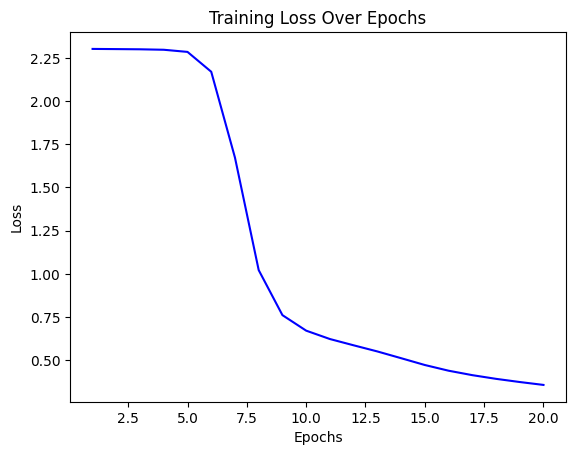

In [ ]:
layers = [
    Layer(input_size=X_train.shape[1], output_size=128, activation_function='relu'),
    Layer(input_size=128, output_size=64, activation_function='relu'),
    Layer(input_size=64, output_size=10, activation_function='softmax'),
]

# Initialize the neural network
nn = NN(layers=layers, num_classes = 10, activation_function='softmax', loss_function='cross_entropy')

# Train the network
epochs = 20
batch_size = 64
learning_rate = 0.01
nn.train(
    X_train, 
    y_train_encoded, 
    epochs=epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate, 
    verbose=True, 
    visualize=True
    )

In [10]:
nn.evaluate(X_test, y_test_encoded)

{'loss': np.float64(0.35095152446038785),
 'accuracy': np.float64(0.8966666666666666),
 'precision': np.float64(0.8948768294891163),
 'recall': np.float64(0.8942699458684483),
 'f1_score': np.float64(0.8942021684325907)}

## Polish Bankruptcy Dataset

In [11]:
X_train = pd.read_csv('data/bankruptcy_train_features.csv').values
X_test = pd.read_csv('data/bankruptcy_test_features.csv').values
y_train = pd.read_csv('data/bankruptcy_train_target.csv').values
y_test = pd.read_csv('data/bankruptcy_test_target.csv').values

### Analytics, Visualizations and Insights

In [12]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([33558,  1166])), (array([0, 1]), array([7756,  925])))

### Custom NN Modeling and Evaluation

 20%|██        | 2/10 [00:00<00:00,  8.82it/s]

Epoch 1/10 ============ Loss: nan
Epoch 2/10 ============ Loss: nan


 40%|████      | 4/10 [00:00<00:00,  7.47it/s]

Epoch 3/10 ============ Loss: nan
Epoch 4/10 ============ Loss: nan


 60%|██████    | 6/10 [00:00<00:00,  8.11it/s]

Epoch 5/10 ============ Loss: nan
Epoch 6/10 ============ Loss: nan


 80%|████████  | 8/10 [00:00<00:00,  8.95it/s]

Epoch 7/10 ============ Loss: nan
Epoch 8/10 ============ Loss: nan


100%|██████████| 10/10 [00:01<00:00,  8.47it/s]

Epoch 9/10 ============ Loss: nan
Epoch 10/10 ============ Loss: nan


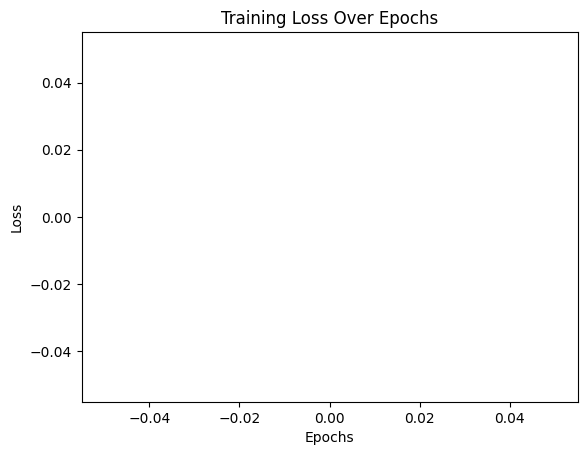

In [20]:
layers = [
    Layer(input_size=X_train.shape[1], output_size=10, activation_function='relu'),
    Layer(input_size=10, output_size=4, activation_function='relu'),
    Layer(input_size=4, output_size=1, activation_function='relu'),
]

# Initialize the neural network
nn = NN(layers=layers, num_classes = 1, activation_function='relu', loss_function='mean_squared_error')

# Train the network
epochs = 10
batch_size = 1000
learning_rate = 0.001
nn.train(
    X_train, 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate, 
    verbose=True, 
    visualize=True
    )

In [16]:
nn.evaluate(X_test, y_test)

{'loss': np.float64(nan),
 'accuracy': np.float64(1.0),
 'precision': np.float64(1.0),
 'recall': np.float64(1.0),
 'f1_score': np.float64(1.0)}

### Pytorch Implementation

### LLM Developed NN Implementation

### Comparison Across the Three Implemtations

## 2nd Dataset

### Analytics, Visualization and Insights

### Custom NN Implementation

### Pytorch Implementation

### LLM Developed NN Implementation

### Comparison Across the Three Implemtations